In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import os
import matplotlib.dates as mdates
import shutil
import sys
from configobj import ConfigObj
import json
from distutils.util import strtobool
import h5py
# from calfews_src.model_cy cimport Model
from calfews_src.inputter_cy import Inputter
from calfews_src.scenario import Scenario
from calfews_src.util import *
from calfews_src.plotter import *
from calfews_src.visualizer import Visualizer
from datetime import datetime

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, cross_val_predict
from sklearn.metrics import make_scorer, r2_score
from sklearn.linear_model import Lasso
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import ElasticNetCV, ElasticNet
from sklearn.model_selection import GridSearchCV, KFold

from matplotlib import pyplot

import joblib
import warnings
warnings.filterwarnings('ignore', category=RuntimeWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)
pd.options.mode.chained_assignment = None  # default='warn'
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

# os.chdir("C:/Users/danli/OneDrive - University of North Carolina at Chapel Hill/github/CALFEWS")
os.getcwd()

'c:\\Users\\danli\\OneDrive - University of North Carolina at Chapel Hill\\github\\CALFEWS_waterFutures'

# HMM analysis

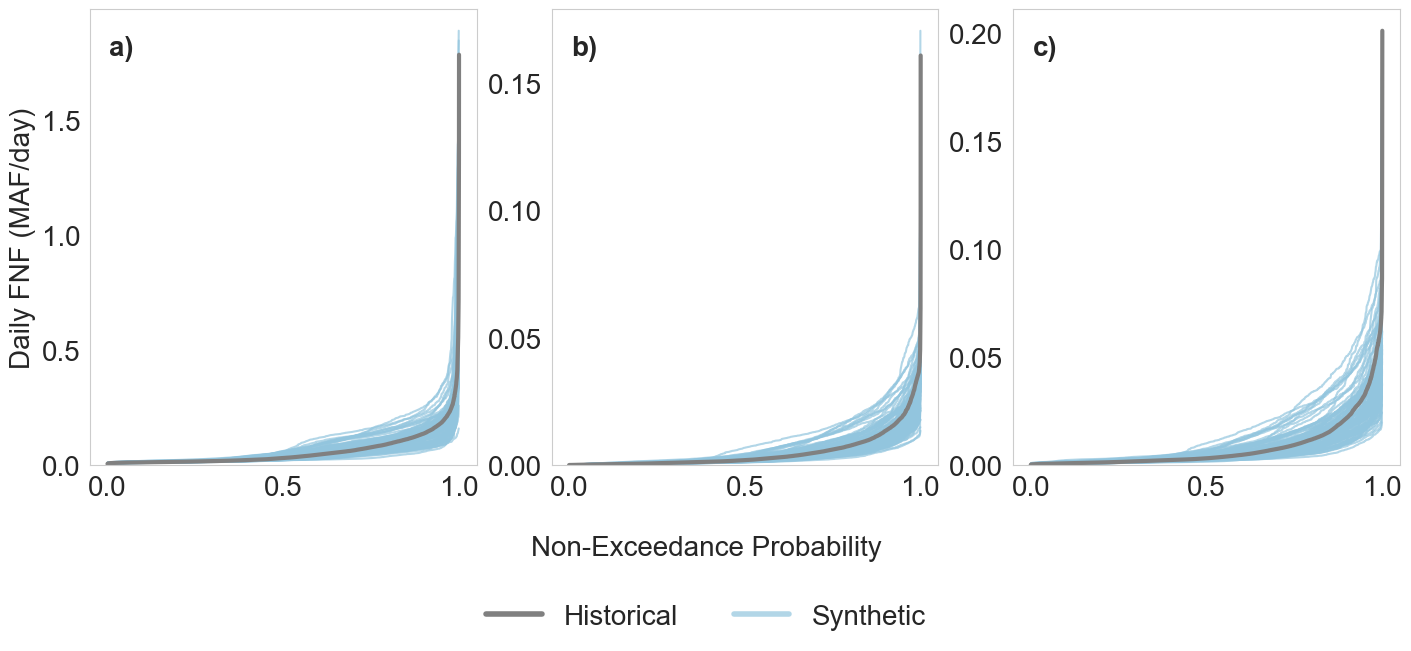

In [25]:
Q_data_file ='calfews_src/data/input/calfews_src-data.csv'
output_folder = "calfews_src/data/MGHMM_synthetic/"

historical_data = pd.read_csv(Q_data_file, header=1)
historical_sum_Q_Z = historical_data.iloc[:, np.r_[16:20, 23:26]].sum(axis=1)/1000000  # Assuming columns Q (2) to Z (25)
historical_AA = historical_data.iloc[:, 26]/1000000  # Assuming column AA (26)
historical_sum_AB_AE = historical_data.iloc[:,27:31].sum(axis=1)/1000000  # Assuming columns AB (27) to AE (30)

# Read the synthetic ensemble data
data_dict_sum_E_N = {}
data_dict_O = {}
data_dict_sum_P_S = {}
for i in range(0, 100):
    output_file = os.path.join(output_folder, f'DailyQ_s{i}.csv')
    input_data = pd.read_csv(output_file)
    
    data_dict_sum_E_N[f'Trace {i}'] = input_data.iloc[:, np.r_[4:8,11:14]].sum(axis=1).values/1000000  # Columns E (4) to N (14)
    data_dict_O[f'Trace {i}'] = input_data.iloc[:, 14].values/1000000  # Column O (15)
    data_dict_sum_P_S[f'Trace {i}'] = input_data.iloc[:, 15:19].sum(axis=1).values/1000000  # Columns P (16) to S (19)

def plot_non_exceedance(data, ax, label=None, color=None, alpha=None, linewidth=None):
    sorted_data = np.sort(data)
    n = len(sorted_data)
    probabilities = np.arange(1, n + 1) / (n + 1)
    ax.plot(probabilities, sorted_data, label=label, color=color, alpha=alpha, linewidth=linewidth)

fig, axs = plt.subplots(1, 3, figsize=(14, 5), constrained_layout=True)

# First subplot: Sum of columns Q to Z for historical, and E to N for synthetic ensemble "Above Millerton"
for trace_data in data_dict_sum_E_N.values():
    plot_non_exceedance(trace_data, axs[0], color='#92c5de', alpha=0.7)
plot_non_exceedance(historical_sum_Q_Z, axs[0], label='Historical', color='grey', linewidth=3)

# axs[0].set_title('Sum of Columns Q-Z / E-N')
# axs[0].set_xlabel('Non-Exceedance Probability')
axs[0].set_ylabel('Daily FNF (MAF/day)', fontsize=20)
axs[0].grid(False)
axs[0].locator_params(axis='y', nbins=6)
axs[0].tick_params(axis='both', which='major', labelsize=20)
axs[0].set_ylim(ymin=0)
# Second subplot: Column AA for historical, and O for synthetic ensemble "Millerton" 

for trace_data in data_dict_O.values():
    plot_non_exceedance(trace_data, axs[1], color='#92c5de', alpha=0.7)
plot_non_exceedance(historical_AA, axs[1], label='Historical', color='grey', linewidth=3)
axs[1].grid(False)
# axs[1].set_xlabel("Non-Exceedance\nProbability",fontsize=20)
axs[1].locator_params(axis='y', nbins=6)
#ax[2].set_ylabel('Annual FNF (TL/yr)',fontsize=20)
#ax[2].set_title("South of Millerton",fontsize=22,y=1.08)
axs[1].tick_params(axis='both', which='major', labelsize=20)
axs[1].set_ylim(ymin=0)

# Third subplot: Sum of columns AB to AE for historical, and P to S for synthetic ensemble "Below Millerton"
for trace_data in data_dict_sum_P_S.values():
    plot_non_exceedance(trace_data, axs[2], color='#92c5de', alpha=0.7)
plot_non_exceedance(historical_sum_AB_AE, axs[2], label='Historical', color='grey', linewidth=3)

axs[2].grid(False)
axs[2].locator_params(axis='y', nbins=6)

# axs[2].set_xlabel("Non-Exceedance\nProbability",fontsize=20)
#ax[2].set_ylabel('Annual FNF (TL/yr)',fontsize=20)
#ax[2].set_title("South of Millerton",fontsize=22,y=1.08)
axs[2].tick_params(axis='both', which='major', labelsize=20
                   )
axs[2].set_ylim(ymin=0)

axs[0].text(0.05, 0.90, "a)", fontsize=20, weight="bold", transform=axs[0].transAxes)
axs[1].text(0.05, 0.90, "b)", fontsize=20, weight="bold",transform=axs[1].transAxes)
axs[2].text(0.05, 0.90, "c)", fontsize=20, weight="bold", transform=axs[2].transAxes)
fig.text(0.5, -0.1, 'Non-Exceedance Probability', fontsize=20,ha='center')
# plt.suptitle('Non-Exceedance Probability Plots')
legend_elements = [
    Line2D([0], [0], color='grey', lw=4, label='Historical'),
    Line2D([0], [0], color='#92c5de', lw=4, alpha=0.7, label='Synthetic')
]

fig.legend(handles=legend_elements, loc='lower center', ncol=2, fontsize=20, frameon=False, bbox_to_anchor=(0.5, -0.3))
plt.savefig('Figure/non_exceedance_probability_plots.png', dpi=300, bbox_inches='tight')   
plt.show()

# Pre-processing of input files

In [26]:
# from pathlib import Path
# folder_path = Path("calfews_src/data/MGHMM_synthetic/")
# csv_files = folder_path.glob("DailyQ_s0.csv")

# for csv_file in csv_files:

#     df = pd.read_csv(csv_file)
#     df['Date'] = pd.to_datetime(df[['Year', 'Month', 'Day']])
#     df.set_index('Date', inplace=True)
#     df.drop(['Year', 'Month', 'Day'], axis=1, inplace=True)
#     df.to_csv(csv_file)

#     print(f"Processed {csv_file}")

In [6]:
from datetime import datetime, timedelta
input_folder_path = 'calfews_src/data/MGHMM_synthetic/start_year/'
output_folder_path = 'calfews_src/data/MGHMM_synthetic/start_year/'

# Create output folder if it doesn't exist
if not os.path.exists(output_folder_path):
    os.makedirs(output_folder_path)

# Function to modify dates and filter rows
def filter_dates(input_file, output_folder):
    # Read the data
    df = pd.read_csv(input_file)

    # Cut until row 1096
    df = df.iloc[:1095]

    # Adjust the Year, Month, Day columns to range from 2024-10-01 to 2027-10-01
    start_date = datetime(2024, 10, 1)
    date_range = [start_date + timedelta(days=i) for i in range(len(df))]

    # Update the Year, Month, Day columns
    df['Year'] = [date.year for date in date_range]
    df['Month'] = [date.month for date in date_range]
    df['Day'] = [date.day for date in date_range]

    # Define the output file path
    output_file = os.path.join(output_folder, os.path.basename(input_file))

    # Save the modified dataframe to the output folder
    df.to_csv(output_file, index=False)

# Process all files in the folder
filenames = [f'DailyQ_s_{year}_{i}.csv' for year in range(1996, 2025) for i in range(100)]

for filename in filenames:
    file_path = os.path.join(input_folder_path, filename)
    filter_dates(file_path, output_folder_path)

In [ ]:

# def filter_dates(file_path, output_folder):
#     df = pd.read_csv(file_path)
    
    
#     df['Date'] = pd.to_datetime(df[['Year', 'Month', 'Day']])
    
#     # Define the original and new date ranges
#     original_start_date = pd.Timestamp('2024-10-02')
#     original_end_date = pd.Timestamp('2027-10-02')
#     new_start_date = pd.Timestamp('2024-10-01')
#     new_end_date = pd.Timestamp('2027-10-30')
   
#     date_shift = new_start_date - original_start_date
 
#     df['Date'] = df['Date'] + date_shift
#     df['Year'] = df['Date'].dt.year
#     df['Month'] = df['Date'].dt.month
#     df['Day'] = df['Date'].dt.day

#     df.drop(columns=['Date'], inplace=True)

#     output_file_path = os.path.join(output_folder, os.path.basename(file_path))
#     df.to_csv(output_file_path, index=False)

# # Define folder paths
# input_folder_path = 'calfews_src/data/MGHMM_synthetic/start_year/'
# output_folder_path = 'calfews_src/data/MGHMM_synthetic/start_year/'

# # Create output folder if it doesn't exist
# if not os.path.exists(output_folder_path):
#     os.makedirs(output_folder_path)

# # Process all files in the folder
# # filenames = [f'DailyQ_s{i}.csv' for i in range(100)]
# filenames = [f'DailyQ_s_{year}_{i}.csv' for year in range(1996, 2025) for i in range(100)]


# for filename in filenames:
#     file_path = os.path.join(input_folder_path, filename)
#     filter_dates(file_path, output_folder_path)

In [ ]:
# cut the synthetic data to water years to run CALFEWS

# def filter_dates(file_path):
#     df = pd.read_csv(file_path)
    
#     df['Date'] = pd.to_datetime(df[['Year', 'Month', 'Day']])
#     start_date = pd.Timestamp('2024-10-01')
#     end_date = pd.Timestamp('2027-9-30')
    
#     filtered_df = df[(df['Date'] >= start_date) & (df['Date'] <= end_date)]
#     filtered_df = filtered_df.drop(columns=['Date'])
#         # Drop the last row
#     # if not filtered_df.empty:
#     #     filtered_df = filtered_df.iloc[:-1]
#     filtered_df.to_csv(file_path, index=False)

# folder_path = 'calfews_src/data/MGHMM_synthetic/start_year/'
# # filenames = [f'DailyQ_s{i}.csv' for i in range(100)]
# filenames = [f'DailyQ_s_{year}_{i}.csv' for year in range(1996, 2025) for i in range(100)]


# for filename in filenames:
#     file_path = os.path.join(folder_path, filename)
#     filter_dates(file_path)

# Data merging & functions to use

In [29]:
#Load data (NQH2O water price index)
NQH2O_hist = pd.read_excel('calfews_src/data/price_index/NQH2O_20180801-20240819.xlsx')
NQH2O_hist.rename({'Trade Date': 'Date', 'Index Value': 'NQH2O'}, axis=1, inplace=True)
NQH2O_hist = NQH2O_hist[['Date', 'NQH2O']]

NQH2O_pre = pd.read_csv('calfews_src/data/price_index/AdditionalData_NQH2O.csv', encoding='ISO-8859-1')
NQH2O_pre = NQH2O_pre[['Date', 'NQH2O']]
NQH2O_pre['Date'] = pd.to_datetime(NQH2O_pre['Date'])

combined_df = pd.concat([NQH2O_hist, NQH2O_pre]).sort_values(by='Date')
combined_df.reset_index(drop=True, inplace=True)

combined_df['Date'] = pd.to_datetime(combined_df['Date'])
combined_df['9_Month_Forward_Avg'] = np.nan

# Function to calculate 9-month forward average of the 'NQH2O' prices based on a 3-month window
def calculate_9_month_forward_avg(current_date, df):
    target_date = current_date + pd.DateOffset(months=9)
    window_start = target_date - pd.DateOffset(months=1)
    window_end = target_date + pd.DateOffset(months=1)
    
    mask = (df['Date'] >= window_start) & (df['Date'] <= window_end)
    relevant_prices = df.loc[mask, 'NQH2O']
    
    if len(relevant_prices) > 0:
        return relevant_prices.mean()
    else:
        return None

combined_df['9_Month_Forward_Avg'] = combined_df['Date'].apply(lambda x: calculate_9_month_forward_avg(x, combined_df))
cutoff_date = pd.to_datetime('2024-01-01')
combined_df.loc[combined_df['Date'] > cutoff_date, '9_Month_Forward_Avg'] = np.nan
# combined_df['NQH2O_past3M'] = combined_df['NQH2O'].rolling(window='90D', min_periods=3).mean()
# combined_df['NQH2O_f9_past3M'] = combined_df['9_Month_Forward_Avg'].rolling(window='90D', min_periods=3).mean()
combined_df

,Date,NQH2O,9_Month_Forward_Avg
0,2013-01-09,222.02,282.813333
1,2013-01-16,146.89,283.800000
2,2013-01-23,113.34,285.757778
3,2013-01-30,109.68,288.353333
4,2013-02-06,109.77,291.208889
...,...,...,...
634,2024-09-25,431.69,NaN
635,2024-09-26,431.69,NaN
636,2024-09-27,431.69,NaN
637,2024-09-30,431.69,NaN


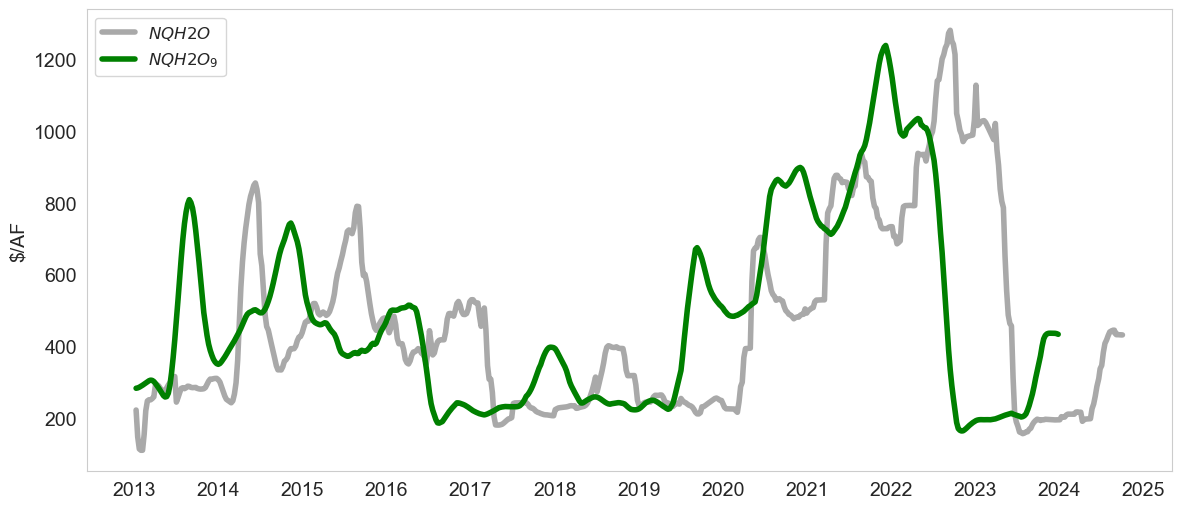

In [30]:
#Figures to compare NQH2O and 9-month forward average
plt.figure(figsize=(14, 6))

plt.plot(combined_df['Date'], combined_df['NQH2O'], label=r'$NQH2O$', linestyle='-', color='darkgrey', linewidth=4)
plt.plot(combined_df['Date'], combined_df['9_Month_Forward_Avg'], label=r'$NQH2O_{9}$', linestyle='-', color='green', linewidth=4)
plt.ylabel('$/AF', fontsize=14)
# plt.ylim(0, 1400)
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=12, loc='upper left')
plt.grid(False)
plt.show()

In [31]:
#around 100 columns do not exisit in the synthetic data, remove those features in the validation data (short-test, 28-year run) that will be used to train the model
reference_file = 'results/1_2024/results.hdf5'
output_folder = "results/short_test/"
output_file = output_folder + 'results.hdf5'
fig_folder = output_folder + 'figs/'

reference_df = get_results_sensitivity_number_outside_model(reference_file, '')
datDaily = get_results_sensitivity_number_outside_model(output_file, '')

reference_columns = set(reference_df.columns)
datDaily_columns = set(datDaily.columns)

columns_to_remove = datDaily_columns - reference_columns
datDaily.drop(columns=columns_to_remove, inplace=True)

print(f"Number of columns removed: {len(columns_to_remove)}")
print("Removed columns in datDaily:")
print(columns_to_remove)

Number of columns removed: 309
Removed columns in datDaily:
{'terra_kaweah_flood_irrigation', 'otherexchange_exchange_turnback', 'northkern_kings_flood', 'kgr_FKC_flow', 'kerntulare_RRB_recharged', 'sosanjoaquin_kings_flood_irrigation', 'berrenda_friant1_flood', 'bakersfield_pumping', 'pineflat_flood_deliveries', 'tejon_tule_flood_irrigation', 'alta_kings_flood', 'lindsay_kings_flood_irrigation', 'centralcoast_tableA_turnback', 'othercrossvalley_kings_flood_irrigation', 'kcwa_kern_flood', 'tejon_kings_flood', 'ID4_B2800_recharged', 'berrenda_kings_flood', 'lowertule_tule_flood_irrigation', 'tularelake_kings_flood_irrigation', 'wonderful_LHL_friant1_flood', 'buenavista_kern_flood', 'tejon_kaweah_flood_irrigation', 'wonderful_BDM_cvc_delivery', 'buenavista_tule_flood_irrigation', 'delano_tule_flood', 'wonderful_BDM_cvpdelta_delivery', 'kerndelta_tule_flood_irrigation', 'ID4_friant1_flood_irrigation', 'rosedale_tableA_paper', 'otherfriant_friant2_recharged', 'tejon_friant1_flood', 'otherk

In [32]:
# load short-test output (1996-2024) 
# rolling average of the model output

window_size = '5D'  # Compute the rolling average to smooth the data
average_values_df = datDaily.rolling(window=window_size, center=False).mean()  #make sure center is False so it is indeed a trailing window
merged_df = pd.merge(average_values_df, combined_df, left_on=average_values_df.index, right_on='Date')

In [33]:
def remove_duplicate_columns(df): # this is necessary for aligning features between the short-test output and 2 year synthetic run (there are duplicate columns in the short-test output)
    duplicated_columns = df.columns[df.columns.duplicated()]
    
    print(f"Duplicate columns found: {duplicated_columns.tolist()}")
    columns_to_drop = []
    
    # Iterate through the duplicated columns and mark all but the first occurrence for dropping
    for col in duplicated_columns:
       
        col_indices = [i for i, x in enumerate(df.columns) if x == col]
        columns_to_drop.extend(col_indices[1:])
    df = df.drop(df.columns[columns_to_drop], axis=1)
    
    return df

In [34]:
def ensure_columns_match(df, reference_columns, fill_value='mean', fallback_value= 0):
    for col in reference_columns:
        if col not in df.columns:
            df[col] = np.nan
    
    # Ensure columns match the reference list
    df = df[reference_columns]
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    for col in numeric_cols:
        mean_value = df[col].mean() if not df[col].isna().all() else fallback_value
        df[col].fillna(mean_value, inplace=True)

    df[numeric_cols] = df[numeric_cols].clip(lower=np.finfo(np.float64).min, upper=np.finfo(np.float64).max, axis=1)
   
    return df

In [35]:
def calculate_dowy(date):
    if date.month >= 10:
        water_year_start = pd.Timestamp(year=date.year, month=10, day=1)
    else:
        water_year_start = pd.Timestamp(year=date.year - 1, month=10, day=1)
    
    dowy = (date - water_year_start).days + 1
    return dowy

# Predict the index itself based on synthetic traces

In [55]:
merged_df['Date'] = pd.to_datetime(merged_df['Date'])
# merged_df = merged_df[merged_df['Date'] >= '2020-01-03'] # try different training set of data

merged_df['dowy'] = merged_df['Date'].apply(calculate_dowy)  
merged_df.fillna(merged_df.mean(), inplace=True)
# merged_df['y_10d_avg'] = merged_df['NQH2O'].rolling(window=10, min_periods=1).mean()  #add 3 month average of 9 month forward average to capture trend
# merged_df
X = merged_df.drop(columns=['Date', 'NQH2O', '9_Month_Forward_Avg'])
y = merged_df['NQH2O']
non_numeric_columns = X.select_dtypes(['object', 'datetime']).columns
X = X.drop(columns=non_numeric_columns)
X = remove_duplicate_columns(X)

# suffixes = ('dowy','_S', '_Q', '_R', 'flood_spill', '_SNPK',  '_demand','_downstream', '_pump',)
suffixes = ('dowy','_S', '_Q', '_R', 'flood_spill', '_SNPK', '_downstream',  '_pump', '_demand','_carryover', '_allocation', '_paper', '_delivery',) 
filtered_columns = [col for col in X.columns if col.endswith(suffixes)]
X = X[filtered_columns]

exclude_columns = ['dowy' ]
corr_matrix = X.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if column not in exclude_columns and any(upper[column] > 0.8)]   #column != 'dowy' and
if 'porterville_friant1_carryover' in X.columns:
    to_drop.append('porterville_friant1_carryover')
print(f"Number of columns to drop: {len(to_drop)}")
X = X.drop(columns=to_drop)

X

Duplicate columns found: ['socal_tableA_delivery', 'socal_tableA_recharged', 'socal_tableA_projected', 'socal_cvpdelta_dynamic_recharge_cap', 'socal_exchange_dynamic_recharge_cap', 'socal_cvc_dynamic_recharge_cap', 'socal_friant1_dynamic_recharge_cap', 'socal_friant2_dynamic_recharge_cap', 'socal_kaweah_dynamic_recharge_cap', 'socal_tule_dynamic_recharge_cap', 'socal_kern_dynamic_recharge_cap', 'socal_kings_dynamic_recharge_cap', 'socal_RRB_recharged', 'socal_irr_demand', 'socal_tot_demand', 'socal_tableA_paper', 'socal_exchanged_SW', 'socal_tableA_turnback', 'socal_tableA_carryover', 'socal_tableA_dynamic_recharge_cap', 'socal_pumping', 'socal_IVR_recharged', 'centralcoast_tableA_delivery', 'centralcoast_tableA_projected', 'centralcoast_cvpdelta_dynamic_recharge_cap', 'centralcoast_exchange_dynamic_recharge_cap', 'centralcoast_cvc_dynamic_recharge_cap', 'centralcoast_friant1_dynamic_recharge_cap', 'centralcoast_friant2_dynamic_recharge_cap', 'centralcoast_kaweah_dynamic_recharge_cap',

,shasta_S,shasta_R,shasta_Q,shasta_SNPK,shasta_downstream,oroville_R,oroville_downstream,yuba_S,newmelones_S,newmelones_R,...,otherkaweah_kaweah_carryover,otherswp_tableA_carryover,wonderful_LHL_tableA_paper,wonderful_BDM_cvpdelta_paper,wonderful_BLR_tableA_carryover,metropolitan_SOC_tableA_paper,metropolitan_SOC_irr_demand,castaic_SOC_tableA_delivery,castaic_SOC_irr_demand,dowy
0,3388.164576,6.948893,10.973355,27.324,15.536926,3.983207,-2.386116,819.037677,1698.311327,0.447868,...,-0.010341,0.100899,1.413738,-3.234863,-1.132123,0.0,1.111658,15.656355,0.052446,101
1,3428.480212,6.973488,12.076165,28.164,12.674777,3.403240,-0.728331,815.516976,1707.208782,0.474526,...,-0.010341,0.100899,1.025421,-3.208760,-1.132123,0.0,2.178240,16.057875,0.102766,108
2,3449.136080,6.997686,10.046678,28.260,9.165620,3.405223,-0.071405,813.137543,1715.247076,0.523795,...,-0.010341,0.100899,0.642556,-3.182657,-1.132123,0.0,2.624534,16.840193,0.123821,115
3,3485.480411,6.996099,13.713322,28.380,13.706182,3.402843,0.013091,817.682014,1725.507730,0.496740,...,-0.010341,0.100899,0.137198,-3.156554,-1.132123,0.0,3.293128,17.807155,0.155365,122
4,3531.272807,6.988165,13.138116,28.548,10.926545,3.402843,0.236430,817.520979,1732.769773,1.201983,...,-0.010341,0.100899,-0.045645,-3.153790,-1.132123,0.0,2.880680,18.841231,0.135906,129
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
633,2991.629401,11.219291,5.502942,67.430,2.908165,12.666913,-1.816463,789.315631,1890.868772,1.649058,...,0.000000,-0.019344,-0.677405,0.096145,-11.205020,0.0,3.556000,0.000000,0.000000,360
634,2985.558011,12.014992,5.023339,67.430,2.852628,14.418349,-4.462017,786.515629,1890.234061,1.752595,...,0.000000,-0.019344,-0.510107,0.084127,-11.205020,0.0,3.355000,0.000000,0.000000,361
635,2978.206953,11.967390,5.403372,67.430,2.822479,15.065859,-5.159405,783.532246,1889.453367,1.763306,...,0.000000,-0.019344,-0.344204,0.072109,-11.205020,0.0,3.171600,0.000000,0.000000,362
636,2971.304158,11.362234,5.732628,67.430,2.683636,13.747635,-2.799074,780.543652,1888.676243,1.549884,...,0.000000,-0.019344,-0.178642,0.060090,-11.205020,0.0,3.070400,0.000000,0.000000,363


In [56]:
# print column names for X
X.columns



Index(['shasta_S', 'shasta_R', 'shasta_Q', 'shasta_SNPK', 'shasta_downstream',
       'oroville_R', 'oroville_downstream', 'yuba_S', 'newmelones_S',
       'newmelones_R', 'newmelones_downstream', 'donpedro_R',
       'donpedro_downstream', 'sanluisstate_S',
       'sanluisstate_reclaimed_carryover', 'sanluisfederal_S',
       'sanluisfederal_reclaimed_carryover', 'millerton_downstream',
       'isabella_R', 'success_R', 'kaweah_S', 'kaweah_R', 'delta_HRO_pump',
       'delta_TRP_pump', 'delta_swp_allocation', 'friant1_allocation',
       'friant1_carryover', 'friant2_carryover', 'friant2_total_carryover',
       'tableA_carryover', 'tableA_total_carryover', 'cvpdelta_carryover',
       'exchange_allocation', 'exchange_total_carryover',
       'cvc_total_carryover', 'kern_allocation', 'kern_carryover',
       'kern_total_carryover', 'tule_total_carryover', 'kings_carryover',
       'berrenda_tableA_delivery', 'berrenda_irr_demand',
       'berrenda_tot_demand', 'berrenda_tableA_carryov

In [57]:
feature_columns = X.columns.tolist()
joblib.dump(feature_columns, 'feature_columns2.pkl') # save feature columns for prediction later

X_train_val, X_test, y_train_val, y_test, train_date, test_date = train_test_split(X, y, merged_df[['Date', 'NQH2O']], test_size=0.2, random_state=42)
train_date, train_nqh2o = train_date['Date'], train_date['NQH2O']
test_date, test_nqh2o = test_date['Date'], test_date['NQH2O']
X.shape

(638, 92)

In [59]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('rf', RandomForestRegressor(random_state=42))
])

param_grid = {
    'rf__n_estimators': [100, 50, 200],  # Number of trees in the forest
    'rf__max_features': ['sqrt', 'log2'],  # Number of features to consider at each split
    'rf__max_depth': [10, 20],  # Maximum depth of the tree
    'rf__min_samples_split': [2, 5, 10],  # Minimum number of samples required to split an internal node
    'rf__min_samples_leaf': [2, 4]  # Minimum number of samples required to be at a leaf node
}

kf = KFold(n_splits=5, shuffle=True, random_state=42)

grid_search = GridSearchCV(pipeline, param_grid, cv=kf, scoring='r2')
grid_search.fit(X_train_val, y_train_val)

best_pipeline = grid_search.best_estimator_
best_params = grid_search.best_params_
print(f'Best params: {best_params}')
y_pred_test = best_pipeline.predict(X_test)

r2_test = r2_score(y_test, y_pred_test)
print(f'R² score on the test set with optimized RandomForestRegressor: {r2_test:.3f}')

feature_importances = best_pipeline.named_steps['rf'].feature_importances_

coefficients = pd.DataFrame({
    'features': X.columns.tolist(),
    'Importance': feature_importances
})

coefficients['Rank'] = coefficients['Importance'].rank(ascending=False)
coefficients.sort_values(by='Rank')

# Save the best pipeline
joblib.dump(best_pipeline, 'NQH2O_random_forest_pipeline_with_pca.pkl')

Best params: {'rf__max_depth': 20, 'rf__max_features': 'sqrt', 'rf__min_samples_leaf': 2, 'rf__min_samples_split': 2, 'rf__n_estimators': 200}
R² score on the test set with optimized RandomForestRegressor: 0.981


['NQH2O_random_forest_pipeline_with_pca.pkl']

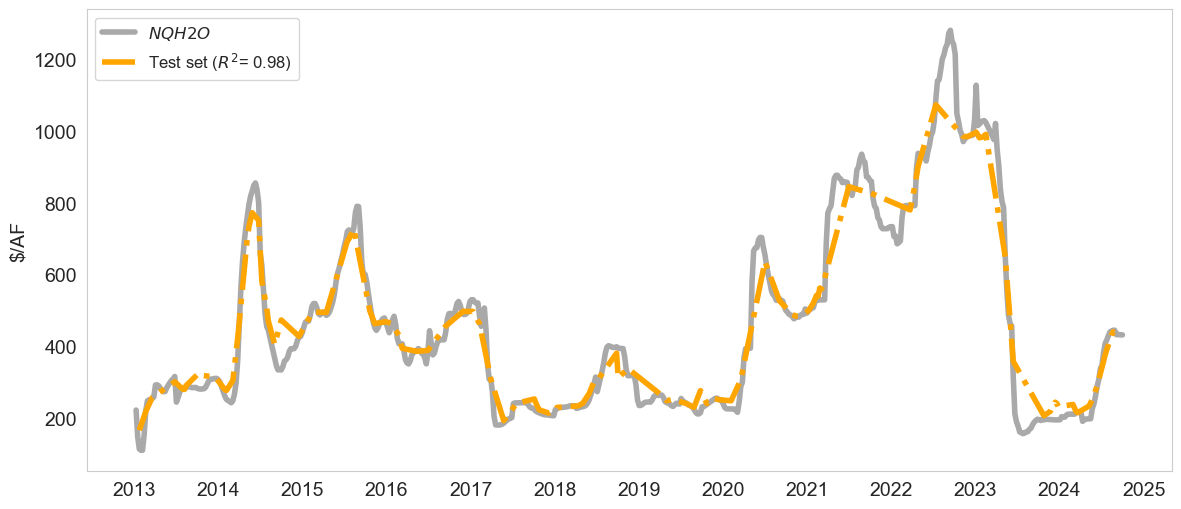

In [60]:
test_results = pd.DataFrame({
    'Date': test_date, 
    'Actual': y_test,
    'NQH2O': test_nqh2o,
    # 'Y_train': y_train_val,
    'Predicted_RandomForest': y_pred_test
})

test_results = test_results.sort_values(by='Date').reset_index(drop=True)
train_results = pd.DataFrame({
    'Date': train_date, 
     'Y_train': y_train_val,})

test_results = test_results.sort_values(by='Date').reset_index(drop=True)
train_results = train_results.sort_values(by='Date').reset_index(drop=True)
plt.figure(figsize=(14, 6))

plt.plot(merged_df['Date'], merged_df['NQH2O'], label=r'$NQH2O$', linestyle='-', color='darkgrey', linewidth=4)
# plt.plot(merged_df['Date'], merged_df['9_Month_F
# orward_Avg'], label=r'$NQH2O_{9}$', linestyle='-', color='green', linewidth=4)

# Plotting predictions on the test set
plt.plot(test_results['Date'], test_results['Predicted_RandomForest'],  # y_pred_test
         label=f'Test set ($R^{{2}}$= {r2_test:.2f})', 
         linestyle='-.', color='orange', linewidth=4)
# plt.plot(train_results['Date'], train_results['Y_train'],  # y_pred_test
#          label=f'Train set', 
#          linestyle='-.', color='green', linewidth=4)

plt.ylabel('$/AF', fontsize=14)
# plt.ylim(0, 1400)
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=12, loc='upper left')
plt.grid(False)

plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


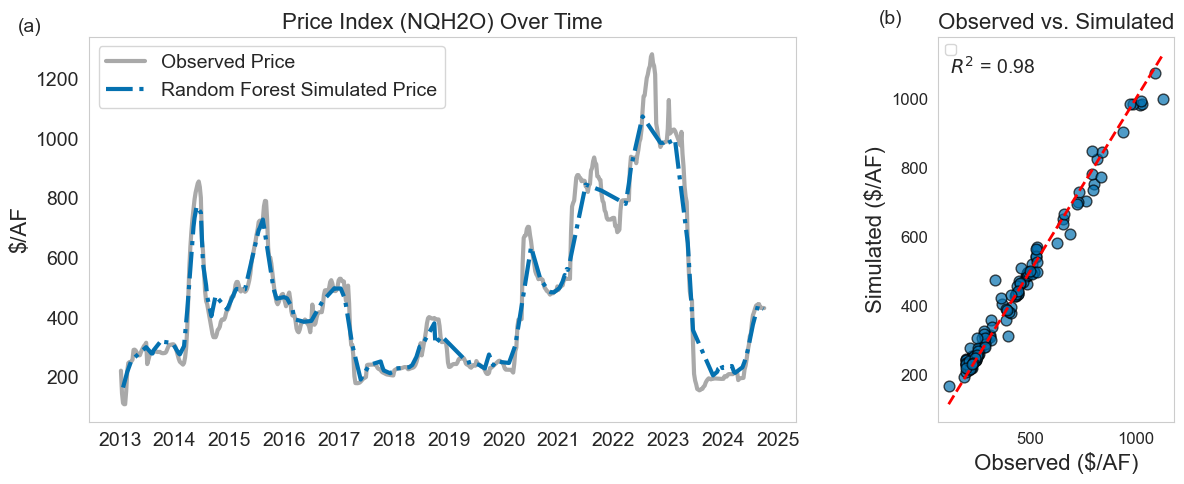

In [61]:
import matplotlib.gridspec as gridspec
fig = plt.figure(figsize=(14, 5))
gs = gridspec.GridSpec(1, 2, width_ratios=[3, 1], wspace=0.3) 
ax1 = fig.add_subplot(gs[0])
ax1.plot(merged_df['Date'], merged_df['NQH2O'], label=r'Observed Price', linestyle='-', color='darkgrey', linewidth=3)
ax1.plot(test_results['Date'], test_results['Predicted_RandomForest'], label='Random Forest Simulated Price', linestyle='-.', color='#0571b0', linewidth=3)
ax1.set_ylabel('$/AF', fontsize=16)
ax1.set_title('Price Index (NQH2O) Over Time', fontsize=16)
ax1.xaxis.set_major_locator(mdates.YearLocator())
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax1.tick_params(axis='x', labelsize=14)
ax1.tick_params(axis='y', labelsize=14)

ax1.legend(fontsize=14, loc='upper left')
ax1.text(-0.1, 1.05, "(a)", transform=ax1.transAxes, fontsize=14, verticalalignment='top')

ax2 = fig.add_subplot(gs[1])

scatter = ax2.scatter( y_test, y_pred_test, color='#0571b0', edgecolor='k', alpha=0.7, s=60
)

max_val = max(max(y_test), max(y_pred_test))
min_val = min(min(y_test), min(y_pred_test))
ax2.plot([min_val, max_val], [min_val, max_val], 
    'r--', linewidth=2, )

ax2.set_xlabel('Observed ($/AF)', fontsize=16)
ax2.set_ylabel('Simulated ($/AF)', fontsize=16)
ax2.set_title('Observed vs. Simulated', fontsize=16)
ax1.grid(False)


# Annotate R² on the plot
ax2.text( 0.05, 0.95, f'$R^{{2}}$ = {r2_test:.2f}', 
    transform=ax2.transAxes, fontsize=14,
    verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.5)
)

ax2.tick_params(axis='x', labelsize=12)
ax2.tick_params(axis='y', labelsize=12)
ax2.legend(fontsize=10)
ax2.grid(False)
ax2.text(-0.25, 1.07, "(b)", transform=ax2.transAxes, fontsize=14, verticalalignment='top')

plt.tight_layout()
plt.savefig('Figure/index_pred_scatter.png', dpi=300)
plt.show()

In [73]:
feature_name_mapping = {
    'newmelones_S': 'New Melones Reservoir Storage',
    'wheeler_tableA_paper': 'Wheeler Ridge-Maricopa ID SWP Paper Balance',
    'losthills_tableA_carryover': 'Lost Hills ID SWP Carry-over Water',
    'dudleyridge_tableA_paper':'Dudley Ridge ID SWP Paper Balance',
      'wheeler_tableA_carryover':'Wheeler Ridge-Maricopa ID SWP Carry-over Water',
                       'shasta_S': 'Shasta Reservoir Storage',
            'cvpdelta_carryover': 'CVP - Delta Division Carry-over Total Deliveries',
     'belridge_tableA_carryover':'Belridge ID SWP Carry-over Water',
   'kerndelta_tableA_carryover':'Kern Delta ID SWP Carry-over Water',
             'kaweah_allocation':'Kaweah Delta ID SWP Allocation',
        'tehachapi_tableA_paper': 'Tehachapi ID SWP Paper Balance',
          'delta_swp_allocation':'Delta SWP Allocation',
      'exeter_friant1_carryover':'Exeter ID Friant Class 1 Carry-over Water',
     'buenavista_kern_carryover':'Buena Vista ID Kern Carry-over Water',
     'berrenda_tableA_carryover':'Berrenda Mesa ID SWP Carry-over Water',
      'belridge_tableA_delivery':'Belridge ID SWP Delivery',
       'buenavista_tableA_paper':'Buena Vista ID SWP Paper Balance',
      'kerndelta_kern_carryover':'Kern Delta ID Kern Carry-over Water',
      'berrenda_tableA_delivery':'Berrenda Mesa ID SWP Delivery',
               'kern_allocation': 'Kern River Water Rights Allocation',
               'cawelo_tableA_carryover':'Cawelo ID SWP Carry-over Water',
               'semitropic_tableA_carryover':'Semitropic ID SWP Carry-over Water',
               'henrymiller_tableA_carryover':'Henry Miller ID SWP Carry-over Water',
              'friant2_total_carryover': 'Friant Class 2 Carry-over Water In Storage',
              'losthills_tableA_paper':'Lost Hills ID SWP Paper Balance',
              'rosedale_tableA_delivery':'Rosedale-Rio Bravo ID SWP Delivery',
              'porterville_friant1_carryover': ' Porterville ID Friant Class 1 Carry-over Water',
              'ID4_tableA_delivery':'Improvement District No 4 SWP Delivery',
              'cvc_total_carryover': 'CVP - Cross Valley Contractors Carry-over Water In Storage',
              'kings_carryover': 'Kings River Water Rights Carry-over Total Deliveries',
              'metropolitan_SOC_irr_demand':'Metropolitan Water District Irrigation Demand',
}

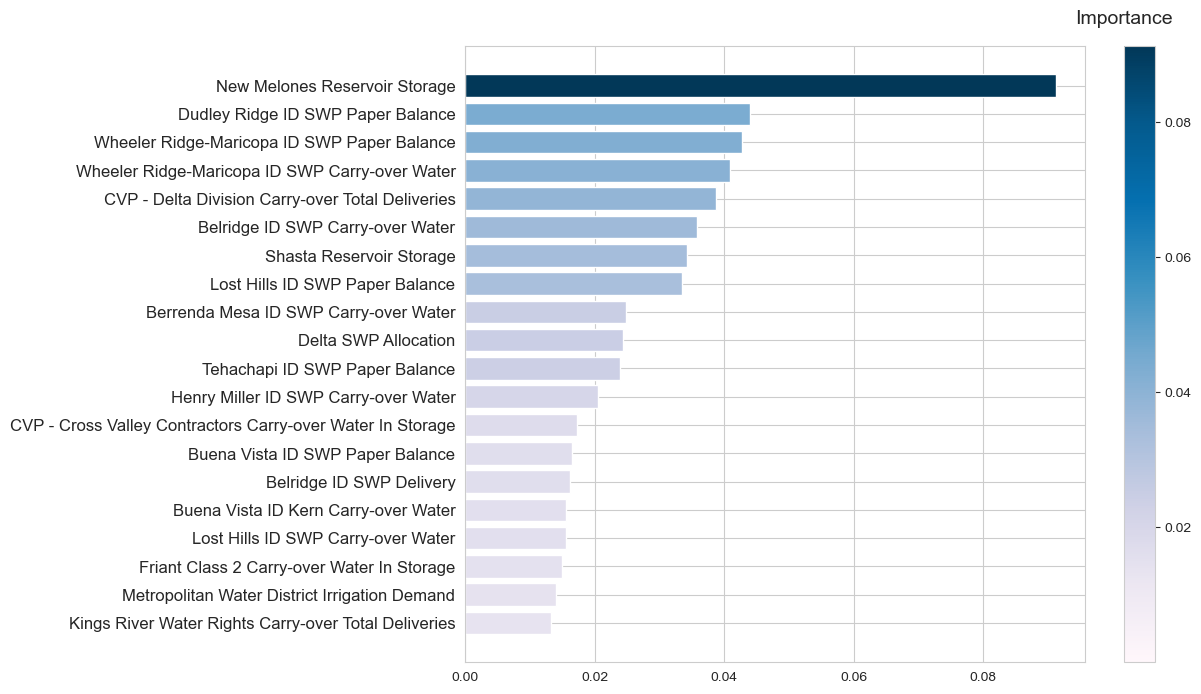

In [74]:
coefficients = pd.DataFrame({
    'features': X.columns.tolist(),
    'Importance': feature_importances
})
# coefficients['features'] = coefficients['features'].map(feature_name_mapping)
coefficients['features'] = coefficients['features'].apply(lambda x: feature_name_mapping.get(x, x))

coefficients = coefficients.sort_values(by='Importance', ascending=False)
coefficients['Rank'] = range(1, len(coefficients) + 1)
cmap = plt.cm.PuBu    # Choose any colormap you like
norm = mpl.colors.Normalize(vmin=coefficients['Importance'].min(), vmax=coefficients['Importance'].max())

top_features = coefficients.head(20)
colors = cmap(norm(top_features['Importance'].values)) 

plt.figure(figsize=(10, 8))
plt.barh(coefficients.head(20)['features'], coefficients.head(20)['Importance'], color=colors)
# plt.xlabel('Importance')
plt.tick_params(axis='y', labelsize=12)

sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # Only needed for older versions of Matplotlib
cbar = plt.colorbar(sm)

cbar.ax.set_ylabel('Importance', rotation=0, labelpad=30, ha='center', va='bottom', fontsize = 14)  # Rotate and position above
cbar.ax.yaxis.set_label_coords(0, 1.03)
plt.gca().invert_yaxis()  # To have the highest rank at the top
plt.savefig('Figure/feature_importance.png', bbox_inches='tight')
plt.show()

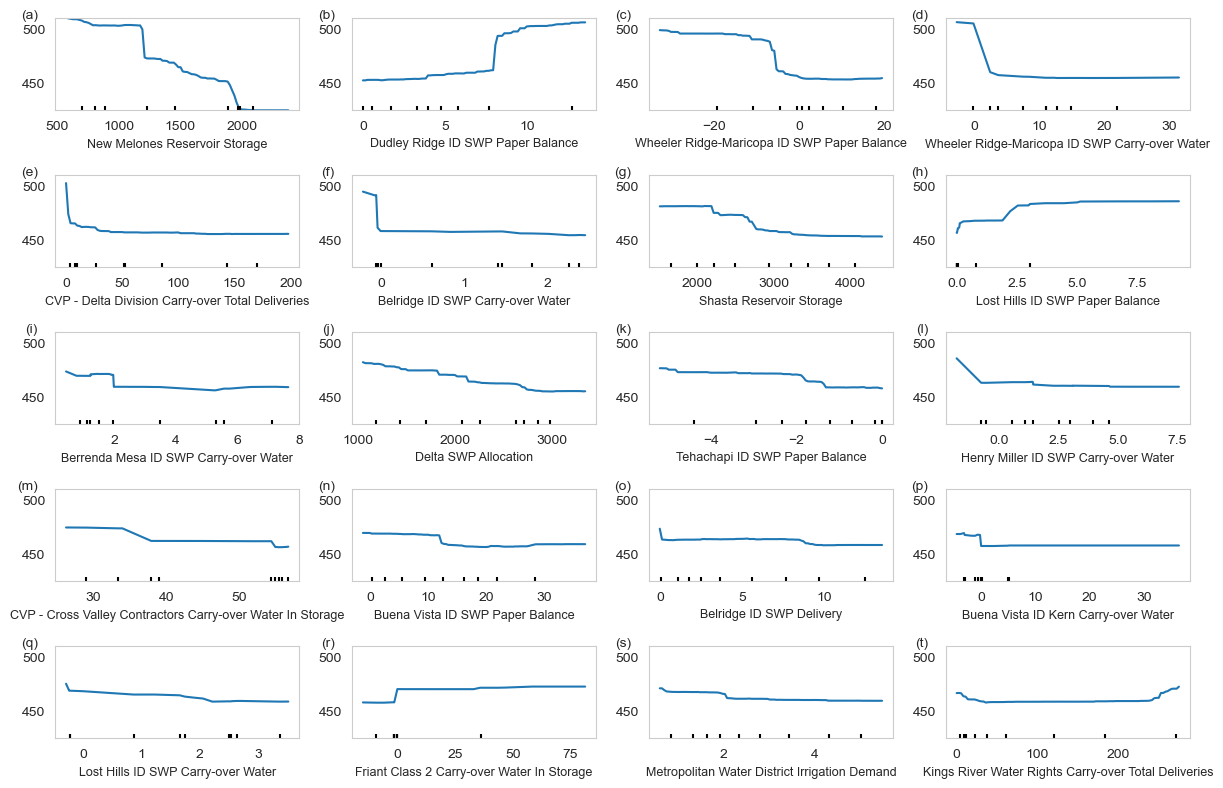

In [76]:
from sklearn.inspection import plot_partial_dependence
import matplotlib.pyplot as plt


reverse_feature_name_mapping = {v: k for k, v in feature_name_mapping.items()}
top_features_orig_names = [reverse_feature_name_mapping.get(name, name) for name in top_features['features']]

fig, ax = plt.subplots(nrows=5, ncols=4, figsize=(12, 8))
ax = ax.flatten()

disp = plot_partial_dependence(
    best_pipeline, X, features=top_features_orig_names, ax=ax
)

# Adjust each subplot
for i, (axi, orig_feature_name) in enumerate(zip(disp.axes_.ravel(), top_features_orig_names)):
    descriptive_name = feature_name_mapping.get(orig_feature_name, orig_feature_name)
    
    # Set the x-label to the descriptive name
    axi.set_xlabel(descriptive_name, fontsize=9)
    
    # Remove the y-label
    axi.set_ylabel('')
    
    # Add a custom label
    label = f"({chr(97 + i)})"
    axi.text(-0.07, 1.09, label, transform=axi.transAxes, 
             size=10, verticalalignment='top', horizontalalignment='right')
    
    # Optionally, remove grid lines
    axi.grid(False)

# Adjust layout
plt.tight_layout()
plt.savefig('Figure/partial_dependence.png', bbox_inches='tight')
plt.show()

In [77]:
random_forest_pipeline_with_pca = joblib.load('NQH2O_random_forest_pipeline_with_pca.pkl')
# elasticnet_pipeline_optimized = joblib.load('elasticnet_pipeline_optimized.pkl')
# pca = joblib.load('pca_model.pkl')

output_folder = 'results/'

plt.figure(figsize=(15, 10))
all_predictions = []
all_indices = []

for scenario_number in range(1, 101):
    scenario_folder = os.path.join(output_folder, f"{scenario_number}_2024")
    output_file = os.path.join(scenario_folder, 'results.hdf5')
    hydro_data = get_results_sensitivity_number_outside_model(output_file, '')

    # Calculate rolling mean
    window_size = '5D'
    X = hydro_data.rolling(window=window_size, center=False).mean()
    X.index.name = 'Date'
    X = X.reset_index()
    X['dowy'] = X['Date'].apply(calculate_dowy) 
    X.set_index('Date', inplace=True)
    X_matched = ensure_columns_match(X, feature_columns)
    
    # Predict y using the model
    predicted_y = random_forest_pipeline_with_pca.predict(X_matched)
    
    # Append the prediction to the lists
    # predictions.append(predicted_y)
    # predicted_y_list.append(predicted_y)

    all_predictions.append(predicted_y)
    all_indices.append(X.index)

<Figure size 1500x1000 with 0 Axes>

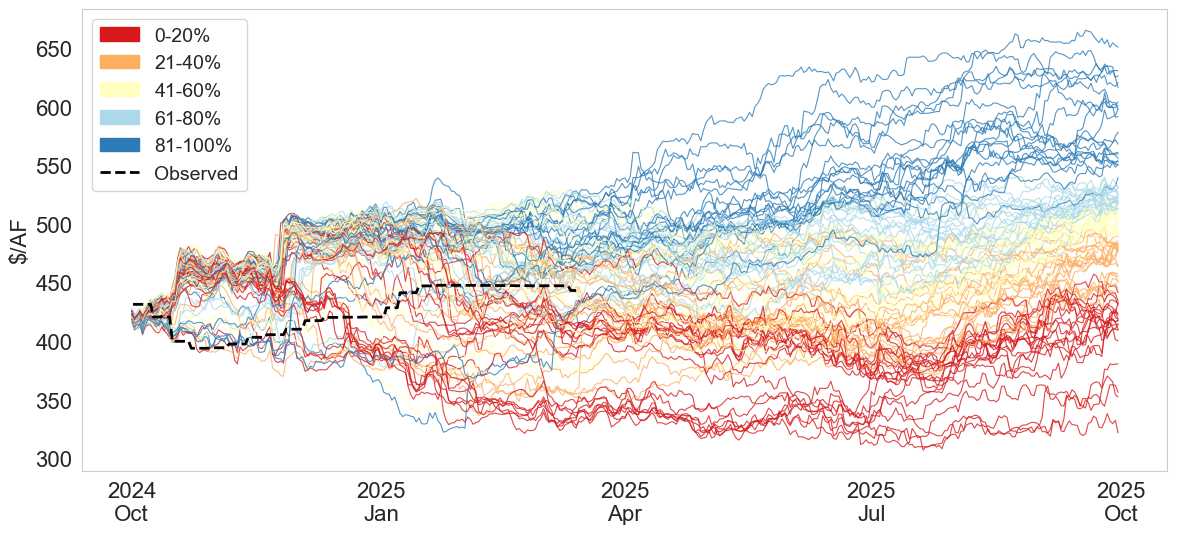

In [ ]:
import matplotlib.patches as mpatches
import matplotlib.dates as mdates

historical_data = pd.read_csv('calfews_src/data/price_index/HistoricalData_102024_012025.csv')  # Replace with your actual file name
historical_data['Date'] = pd.to_datetime(historical_data['Date'])
historical_data.set_index('Date', inplace=True)

plt.figure(figsize=(14, 6))

predictions_array = np.array(all_predictions).T  # Shape: (time points, scenarios)
reference_index = all_indices[0]
predictions_df = pd.DataFrame(predictions_array, index=reference_index, columns=[f'Scenario {i}' for i in range(1, 101)])
# predictions_df.to_csv('water_index_predictions.csv')
predictions_df = predictions_df.iloc[0:365]
predictions_df.index = pd.to_datetime(predictions_df.index)
final_values = predictions_df.iloc[-1]  # Get the last value for each scenario

quintiles = pd.qcut(final_values, 5, labels=False)  # Labels 0 to 4

custom_palette = ['#d7191c', '#fdae61', '#ffffbf', '#abd9e9', '#2c7bb6']

color_mapping = quintiles.map(lambda x: custom_palette[x])

scenarios_to_plot = [f'Scenario {i}' for i in range(1, 101)]
for column in scenarios_to_plot:
    plt.plot(predictions_df.index, predictions_df[column], color=color_mapping[column], linewidth=0.8, alpha=0.8)

observed_line, = plt.plot(historical_data.index, historical_data['Close/Last'],color='black',  linewidth=2,  linestyle='--',  label='Observed')


quintile_labels = ['0-20%', '21-40%', '41-60%', '61-80%', '81-100%']
patches = [mpatches.Patch(color=custom_palette[i], label=quintile_labels[i]) for i in range(5)]
plt.legend(handles=patches + [observed_line],
           fontsize=14, title_fontsize=14, loc='upper left')

def two_line_format(x, pos=None):
    date = mdates.num2date(x)

    return f'{date.year}\n{date.strftime("%b")}'

# Format the x-axis to show year and month in two lines
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(bymonth=[1, 4, 7, 10]))  # Start of each quarter
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(two_line_format))


plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.ylabel('$/AF', fontsize=16)
plt.grid(False)
# plt.tight_layout()
plt.savefig('Figure/scenario_predictions.png', bbox_inches='tight')
plt.show()


In [80]:
# predictions_df.iloc[0:365].describe()   
highest_points = predictions_df.iloc[0:365].max().max()
lowest_points = predictions_df.iloc[0:365].min().min()
print(f"highest points: {highest_points}")
print(f"lowest points: {lowest_points}")
lowest_points


highest points: 665.2638043452379
lowest points: 307.09102101190473


307.09102101190473

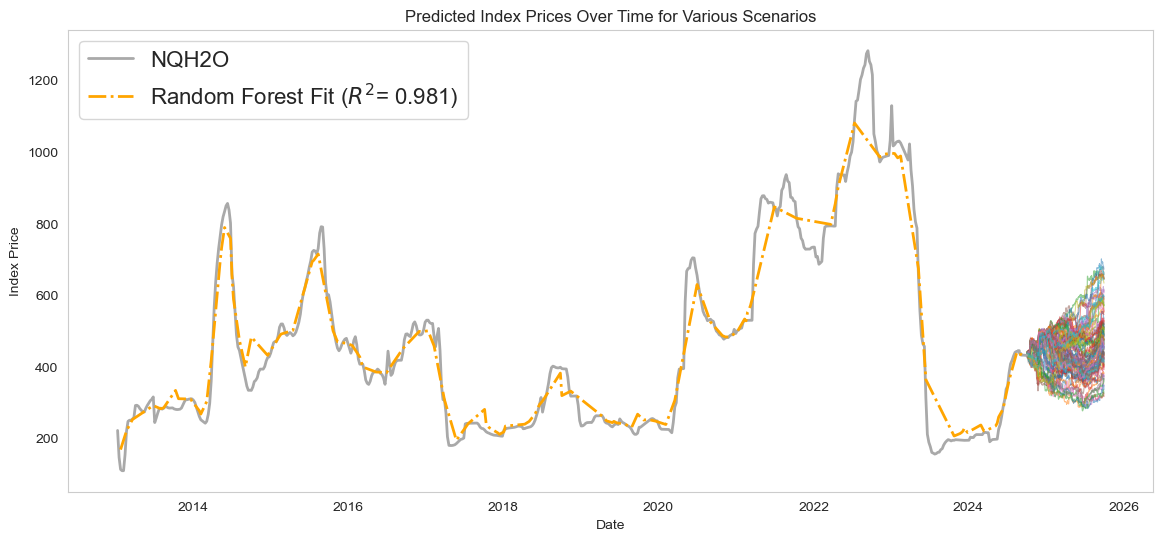

In [48]:
plt.figure(figsize=(14, 6))
scenarios_to_plot = [f'Scenario {i}' for i in range(1, 101)]
for column in scenarios_to_plot:
    plt.plot(predictions_df.index, predictions_df[column],  linewidth=0.8, alpha=0.5)

merged_shifted_dates = merged_df['Date'] + pd.DateOffset(months=9)
# test_shifted_dates = test_results['Date'] + pd.DateOffset(months=9)
# pred_shifted_dates = prediction_results['Date'] + pd.DateOffset(months=9)
plt.plot(merged_df['Date'], merged_df['NQH2O'], label='NQH2O', linestyle='-', color='darkgrey', linewidth=2)
# plt.plot(merged_shifted_dates, merged_df['9_Month_Forward_Avg'], label='NQH2O (9-M Forward Avg)', linestyle='-', color='green', linewidth=2)
plt.plot(test_results['Date'], test_results['Predicted_RandomForest'], 
         label=f'Random Forest Fit ($R^{{2}}$= {r2_test:.3f})', 
         linestyle='-.', color='orange', linewidth=2)
# plt.plot(pred_shifted_dates, prediction_results['Predicted_RandomForest'], 
#          label='Predicted Forward', linestyle='-.', color='gold', linewidth=2)
plt.xlabel('Date')
plt.ylabel('Index Price')
plt.legend(fontsize=16)
plt.grid(False)
# plt.ylim(250, 750)
plt.title('Predicted Index Prices Over Time for Various Scenarios')
plt.show()

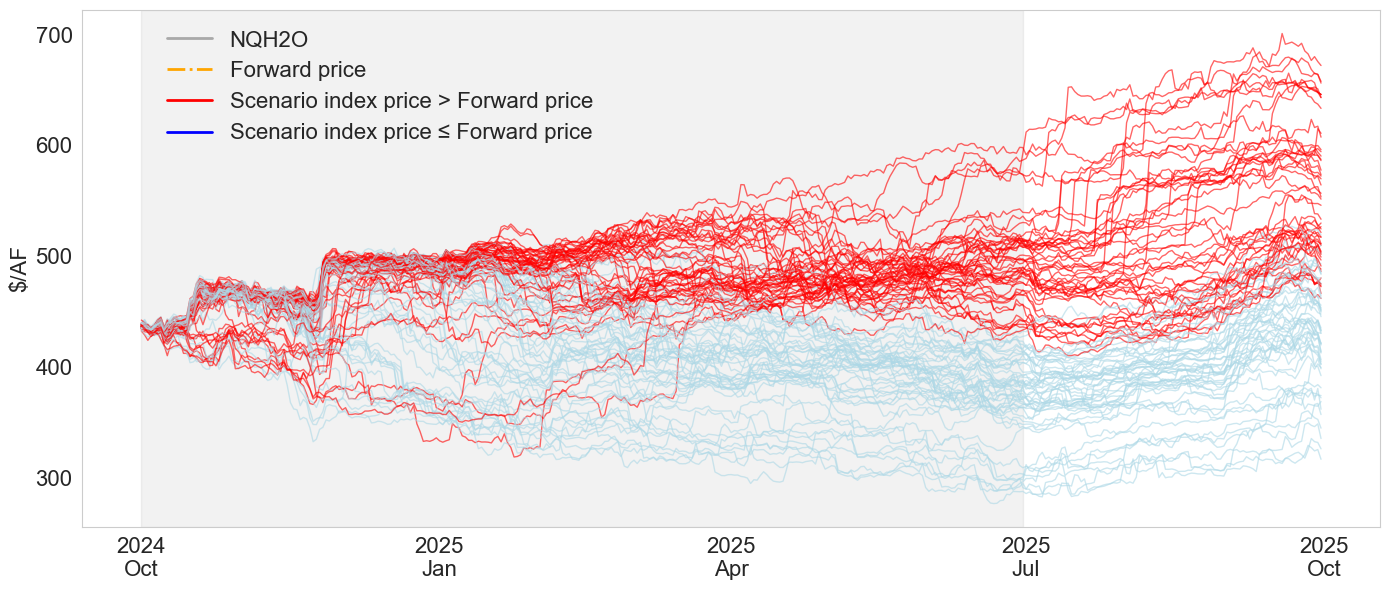

In [49]:
from matplotlib.lines import Line2D

# --- Step 1: Data Preparation ---
plt.figure(figsize=(14, 6))
merged_df['Date'] = pd.to_datetime(merged_df['Date'])
test_results['Date'] = pd.to_datetime(test_results['Date'])
predictions_df['Date'] = pd.to_datetime(predictions_df.index)

merged_df['Date_shift']  = merged_df['Date'] + pd.DateOffset(months=9)
test_results['Date_shift'] = test_results['Date'] + pd.DateOffset(months=9)
predictions_df['Date_shift'] = predictions_df['Date'] + pd.DateOffset(months=9)

# --- Step 2: Plotting ---
last_rf_date = pd.Timestamp('2025-6-30')

higher_scenarios = []
lower_scenarios = []

scenarios_to_plot = [f'Scenario {i}' for i in range(1, 101)]

colors = []

for scenario in scenarios_to_plot:

    scenario_pred = predictions_df[scenario]
    
    if last_rf_date in scenario_pred.index:
        scenario_last_pred = scenario_pred.loc[last_rf_date]
    else:
        scenario_last_pred = scenario_pred.loc[:last_rf_date].iloc[-1]

    rf_last_pred = 433.09 #weighted average by water shortfall

    if scenario_last_pred > rf_last_pred:
        color = 'red'   # Scenario's last prediction is higher than RF's
        higher_scenarios.append(scenario)
    else:
        color = 'lightblue'  # Scenario's last prediction is not higher than RF's
        lower_scenarios.append(scenario)
    
    colors.append(color)
    plt.plot(predictions_df.index, scenario_pred, color=color, linewidth=1, alpha=0.6 )

# plt.plot( merged_df['Date'], merged_df['NQH2O'], label='NQH2O', linestyle='-',  color='darkgrey',  linewidth=4)

# plt.plot(  merged_df['Date_shift'],  merged_df['9_Month_Forward_Avg'], label='NQH2O (9-M Forward Avg)', linestyle='-', color='green', linewidth=4)

# plt.plot(test_results['Date'], test_results['Predicted_RandomForest'], label=f'Test set ($R^{{2}}$= {r2_test:.2f})', linestyle='-.',  color='orange',  linewidth=4)

# # plt.plot(prediction_results['Date_shift'], prediction_results['Predicted_RandomForest'], label='Predicted index price', linestyle='-.', color='gold', linewidth=4)

# plt.title('Predicted Index Prices Over Time for Various Scenarios', fontsize=18, fontweight='bold')
# plt.xlabel('Date', fontsize=14, fontweight='bold')
plt.ylabel('$/AF', fontsize=16)
start_date = pd.to_datetime('2024-10-01')
end_date = pd.to_datetime('2025-06-30')

plt.axvspan(start_date, end_date, color='grey', alpha=0.1, label='Period of Interest')
custom_lines = [
        Line2D([0], [0], color='darkgrey', lw=2, label='NQH2O'),
    # Line2D([0], [0], color='green', lw=2, label=r'$NQH2O_{9}$'),
        # Line2D([0], [0], color='orange', lw=2, linestyle='-.', label=f'Random Forest test set ($R^{{2}}$= {random_forest_test_r2:.2f})'),
    Line2D([0], [0], color='orange', lw=2, linestyle='-.', label='Forward price'),
    # Line2D([0], [0], color='gold', lw=2, linestyle='None', label='Forward price'),
    Line2D([0], [0], color='red', lw=2, label='Scenario index price > Forward price'),
    Line2D([0], [0], color='blue', lw=2, label='Scenario index price ≤ Forward price'),
]

plt.gca().xaxis.set_major_locator(mdates.MonthLocator(bymonth=[1, 4, 7, 10]))  # Start of each quarter
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(two_line_format))
plt.legend(handles=custom_lines, loc='upper left', fontsize=16, framealpha=0, bbox_to_anchor=(0.05, 1),)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.tight_layout()
plt.grid(False)

plt.show()


In [50]:
print("Scenarios with last prediction higher than RF's last prediction:")
for scenario in higher_scenarios:
    print(scenario)

# Option 2: Print scenario numbers only
higher_scenario_numbers = [int(scenario.split(' ')[1]) for scenario in higher_scenarios]
print("\nScenario numbers with last prediction higher than RF's last prediction:")
print(higher_scenario_numbers)

Scenarios with last prediction higher than RF's last prediction:
Scenario 3
Scenario 4
Scenario 5
Scenario 7
Scenario 8
Scenario 9
Scenario 10
Scenario 12
Scenario 13
Scenario 15
Scenario 16
Scenario 18
Scenario 21
Scenario 22
Scenario 25
Scenario 28
Scenario 31
Scenario 33
Scenario 34
Scenario 36
Scenario 37
Scenario 38
Scenario 41
Scenario 44
Scenario 46
Scenario 49
Scenario 51
Scenario 53
Scenario 59
Scenario 60
Scenario 62
Scenario 65
Scenario 66
Scenario 68
Scenario 69
Scenario 70
Scenario 73
Scenario 77
Scenario 79
Scenario 80
Scenario 83
Scenario 84
Scenario 85
Scenario 87
Scenario 89
Scenario 92
Scenario 94
Scenario 99
Scenario 100

Scenario numbers with last prediction higher than RF's last prediction:
[3, 4, 5, 7, 8, 9, 10, 12, 13, 15, 16, 18, 21, 22, 25, 28, 31, 33, 34, 36, 37, 38, 41, 44, 46, 49, 51, 53, 59, 60, 62, 65, 66, 68, 69, 70, 73, 77, 79, 80, 83, 84, 85, 87, 89, 92, 94, 99, 100]


In [51]:
print(last_rf_date)
print(rf_last_pred)

2025-06-30 00:00:00
433.09


In [52]:
# selected_columns = ['Scenario 8', 'Scenario 9', 'Scenario 15', 'Scenario 16', 'Scenario 33', 'Scenario 56','Scenario 79','Scenario 94']

selected_predictions = predictions_df[higher_scenarios]
last_rf_date = pd.Timestamp('2025-6-30')

rf_last_pred = predictions_df.loc[last_rf_date]

scenario_last_pred = selected_predictions.loc[last_rf_date]

payouts = scenario_last_pred - rf_last_pred
payouts_df = payouts.reset_index()
payouts_df.columns = ['Scenario', 'Payout']


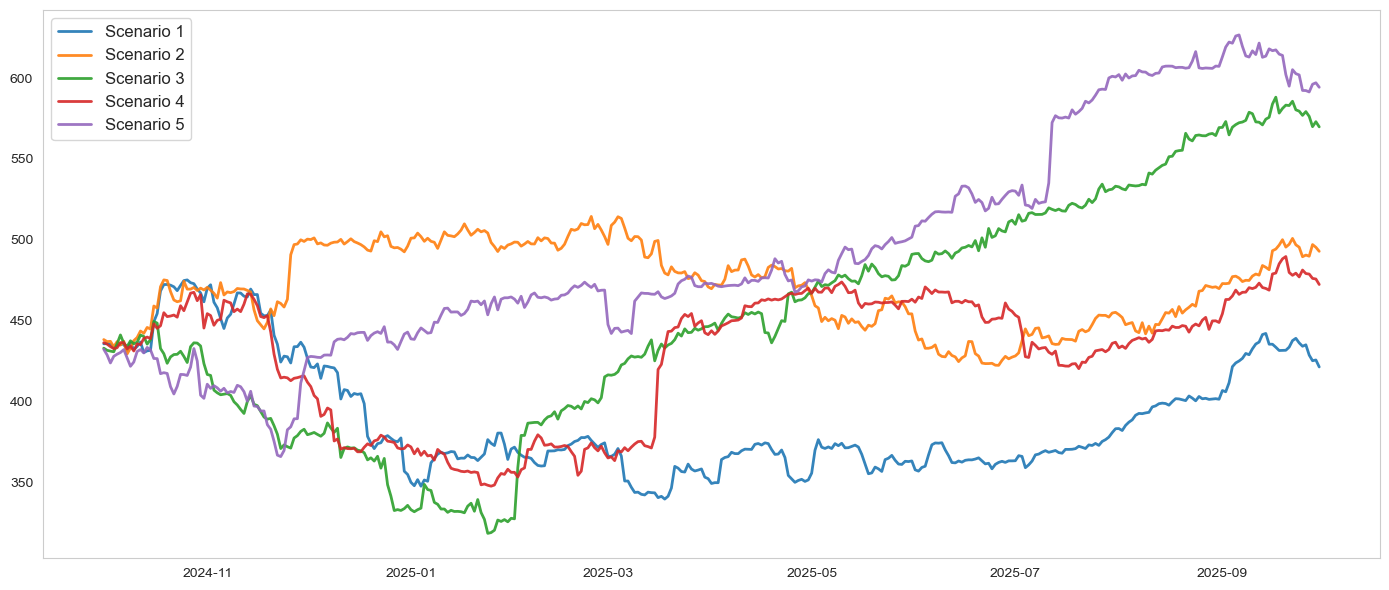

In [53]:
plt.figure(figsize=(14, 6))
scenarios_to_plot = [f'Scenario {i}' for i in [1,2,3,4,5]]
for column in scenarios_to_plot:
    plt.plot(predictions_df.index, predictions_df[column], label=column, linewidth=2, alpha=0.9)
# plt.plot(pred_shifted_dates, prediction_results['Predicted_RandomForest'], label='Predicted index price (RF)', linestyle='-.', color='gold', linewidth=4)
plt.tight_layout()
plt.grid(False)
plt.legend(fontsize=12)
plt.show()

In [54]:
plt.figure(figsize=(12, 5))
output_file = os.path.join('results', str(1), 'results.hdf5')
datDaily_15 = get_results_sensitivity_number_outside_model(output_file, '')
columns_to_plot = [
'newmelones_S',
                      'shasta_S',
              'tehachapi_pumping',
           'delta_swp_allocation',
  'metropolitan_SOC_tableA_paper',
              'kaweah_allocation',
]

num_plots = len(columns_to_plot) + 1

# Create subplots
fig, axes = plt.subplots(nrows=num_plots, ncols=1, figsize=(14, 1.5 * num_plots), sharex=True)
if num_plots == 1:
    axes = [axes]
axes[0].plot(predictions_df.index, predictions_df['Scenario 1'], label='Index price (scenario 1)', color='g', linewidth=2, alpha=0.9)
axes[0].legend(loc='upper left', fontsize=16)
axes[0].xaxis.set_tick_params(labelsize=20)
axes[0].xaxis.grid(False)
axes[0].yaxis.grid(False)

# for ax, column in zip(axes[1:], columns_to_plot):
#     ax.plot(datDaily_15.index, datDaily_15[column], label=column, color='darkgrey')
#     # ax.set_ylabel(column)
#     ax.legend(loc='lower left', fontsize=16)
#     ax.xaxis.grid(False)
#     ax.yaxis.grid(False)

plt.tight_layout()
plt.xticks(fontsize=14)
# plt.yticks(fontsize=14)
plt.show()

FileNotFoundError: [Errno 2] Unable to open file (unable to open file: name = 'results\1\results.hdf5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

<Figure size 1200x500 with 0 Axes>

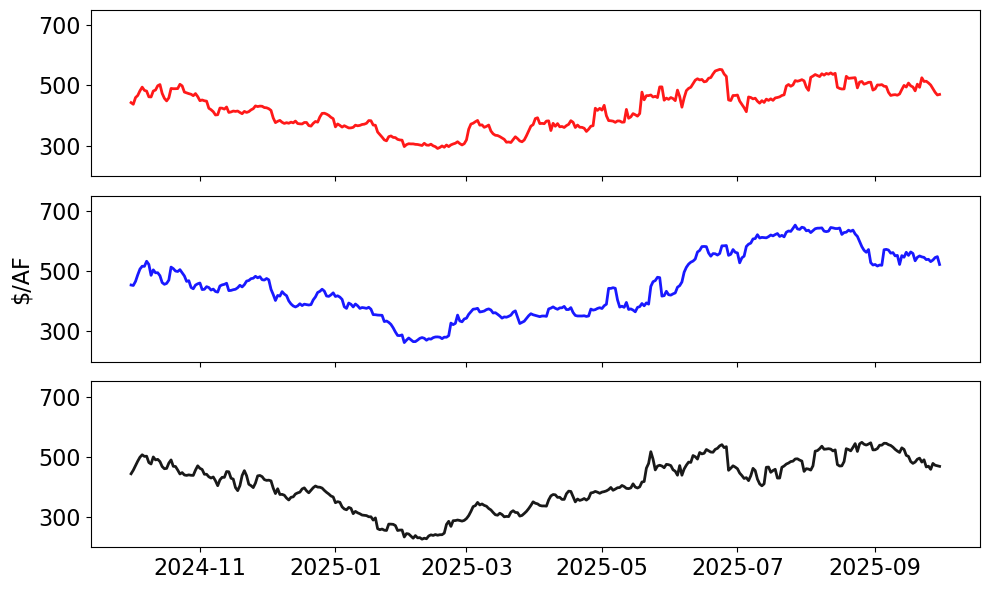

In [ ]:
import matplotlib.pyplot as plt

scenarios = ['Scenario 7', 'Scenario 8', 'Scenario 9']
colors = ['r', 'b', 'black']

num_plots = len(scenarios)

fig, axes = plt.subplots(nrows=num_plots, ncols=1, figsize=(10, 2 * num_plots), sharex=True)

if num_plots == 1:
    axes = [axes]

for ax, scenario, color in zip(axes, scenarios, colors):
    ax.plot(predictions_df.index,  predictions_df[scenario],  label=f'Index Price ({scenario})',  color=color, linewidth=2, alpha=0.9 )
    # ax.legend(fontsize=12, loc='upper left')
    ax.set_ylim(200, 750)
    ax.set_yticks([300, 500, 700])
    # ax.tick_params(axis='y', size=16)
    # ax.set_ylabel('$/AF', fontsize=16) 
    ax.tick_params(axis='y', labelsize=16)
    # ax.set_ylabel('Index Price', fontsize=12)
    # ax.set_title(f'Water Index Prediction - {scenario}', fontsize=14)

axes[-2].set_ylabel('$/AF', fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(False)
plt.tight_layout()
plt.show()
